In [1]:
# HIDDEN
from datascience import *
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')

In [2]:
# Some functions for plotting. You don't have to understand how any
# of the functions in this cell work, since they use things we 
# haven't learned about in Data 8.


def resize_window(lim=3.5):
    plots.xlim(-lim, lim)
    plots.ylim(-lim, lim)
    
def draw_line(slope=0, intercept=0, x=make_array(-4, 4), color='r'):
    y = x*slope + intercept
    plots.plot(x, y, color=color)
    
def draw_vertical_line(x_position, color='black'):
    x = make_array(x_position, x_position)
    y = make_array(-4, 4)
    plots.plot(x, y, color=color)
    
def make_correlated_data(r):
    x = np.random.normal(0, 1, 1000)
    z = np.random.normal(0, 1, 1000)
    y = r*x + (np.sqrt(1-r**2))*z
    return x, y

def r_table(r):
    """
    Generate a table of 1000 x,y data points in standard units
    whose correlation is approximately equal to r
    """
    np.random.seed(8)
    x, y = make_correlated_data(r)
    return Table().with_columns('x', x, 'y', y)

## Prediction lines

In [3]:
example = r_table(0.99)
example.show(3)

x,y
0.0912047,-0.0680119
1.09128,1.04391
-1.94697,-1.88316


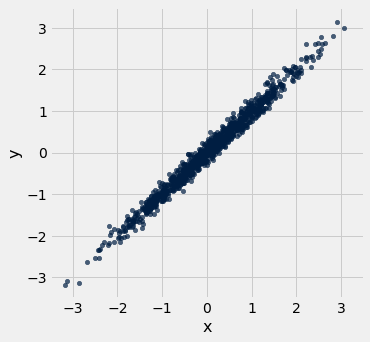

In [4]:
example.scatter('x', 'y')
resize_window()

In [5]:
def nn_prediction_example(x_val, how_close=0.25):
    """
    Predicts y-value for x based on the example table, 
    using points within the specified number of standard units
    """
    neighbors = example.where(
        'x', 
        are.between(x_val - how_close, x_val + how_close)
    )
    return np.mean(neighbors.column('y'))
    

In [6]:
nn_prediction_example(-0.5)

-0.49270067236058596

In [7]:
example = example.with_columns(
    'Predicted y', 
    example.apply(nn_prediction_example, 'x'))

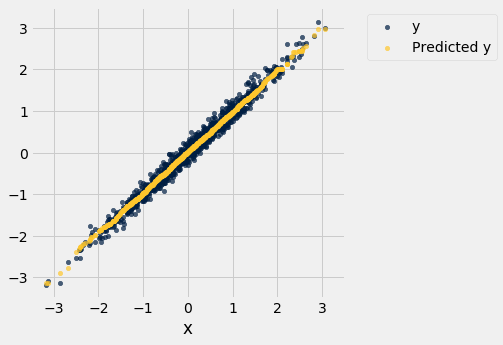

In [8]:
example.scatter('x')
resize_window()

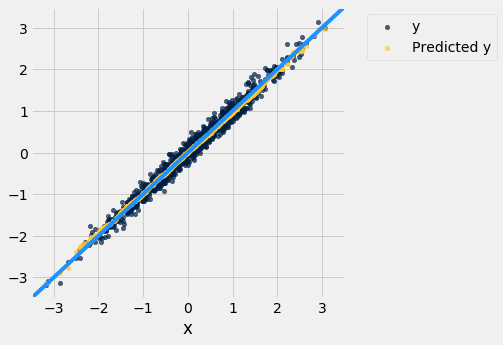

In [9]:
example.scatter('x')
draw_line(slope=1, color='dodgerblue')
resize_window()

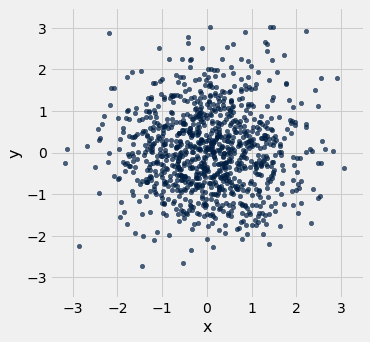

In [10]:
example = r_table(0)
example.scatter('x', 'y')
resize_window()

In [11]:
example = example.with_columns(
    'Predicted y', 
    example.apply(nn_prediction_example, 'x'))

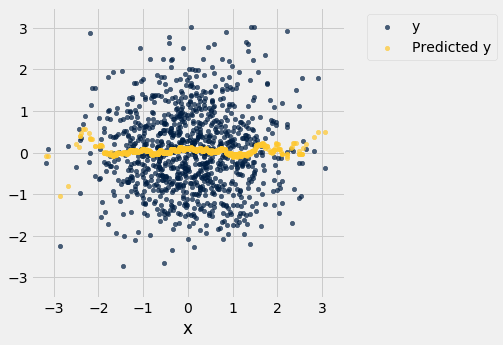

In [12]:
example = example.with_column(
    'Predicted y', example.apply(nn_prediction_example, 'x'))
example.scatter('x')
#draw_line(slope = 0)
resize_window()

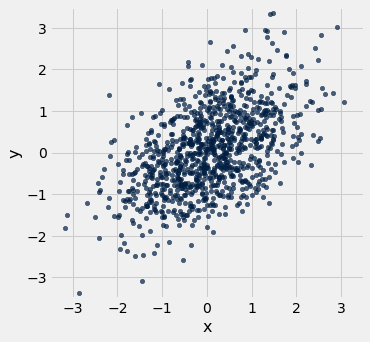

In [13]:
example = r_table(0.5)
example.scatter('x', 'y')
resize_window()

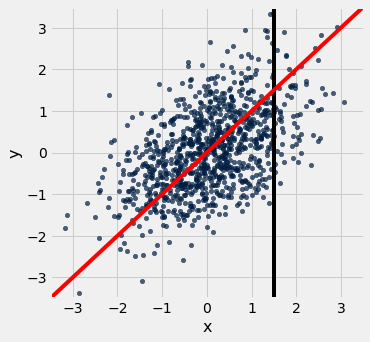

In [14]:
example = r_table(0.5)
example.scatter('x', 'y')
resize_window()
draw_vertical_line(1.5)
draw_line(slope=1, intercept=0)

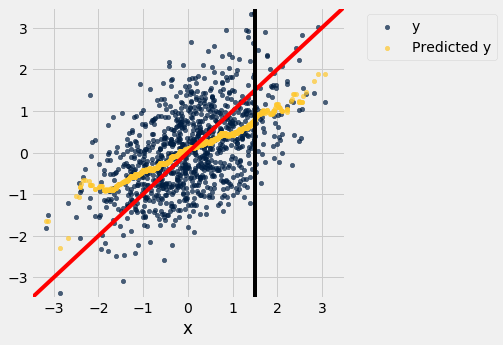

In [15]:
example = example.with_column('Predicted y', example.apply(nn_prediction_example, 'x'))
example.scatter('x')
draw_line(slope=1)
draw_vertical_line(1.5)
resize_window()

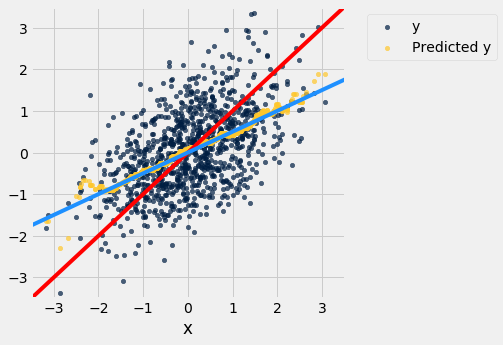

In [16]:
example.scatter('x')
draw_line(slope=1, intercept=0, color='red')
draw_line(slope=0.5, intercept=0, color='dodgerblue')
resize_window()

## Linear regression: defining the line

In [17]:
def standard_units(x):
    """Converts an array x to standard units"""
    return (x - np.mean(x)) / np.std(x)

def correlation(t, x, y):
    x_su = standard_units(t.column(x))
    y_su = standard_units(t.column(y))
    return np.mean(x_su * y_su)


In [18]:
# Hint: see slide 12 of today's lecture for how to define these.
def slope(t, x, y):
    # r * std(y)/std(x)
    sd_y = np.std(t.column(y))
    sd_x = np.std(t.column(x))
    r = correlation(t, x, y)
    return r * (sd_y / sd_x)

def intercept(t, x, y):
    #average of y - slope*average(x)
    avg_y = np.mean(t.column(y))
    avg_x = np.mean(t.column(x))
    m = slope(t, x, y)
    #intercept_compute = np.average(t.column(y)) - slope(t,x,y) * np.average(t.column(x))
    return avg_y - m * avg_x

In [19]:
example = r_table(0.5)
slope(example, 'x', 'y')
intercept(example, 'x', 'y')
example #comparing the scatterplot of example

x,y
0.0912047,-0.926244
1.09128,0.321783
-1.94697,-0.701279
-1.38635,-0.535148
-2.29649,-0.385796
2.40983,2.49743
1.72784,1.1729
2.20456,3.62415
0.794828,0.344429
0.976421,1.80645


## Galton height data

In [20]:
galton = Table.read_table('data/galton.csv')

heights = Table().with_columns(
    'MidParent', galton.column('midparentHeight'),
    'Child', galton.column('childHeight'))
heights

MidParent,Child
75.43,73.2
75.43,69.2
75.43,69
75.43,69
73.66,73.5
73.66,72.5
73.66,65.5
73.66,65.5
72.06,71
72.06,68


In [21]:
m = galton.where('gender', 'female')

np.mean(m.column('mother'))

64.14878587196468

In [22]:
np.mean(m.column('childHeight'))

64.10397350993378

In [23]:
def nn_prediction_galton(h):
    """Return a prediction of the height of a child 
    whose parents have a midparent height of h.
    
    The prediction is the average height of the children 
    whose midparent height is in the range h plus or minus 0.5 inches.
    """
    neighbors = heights.where(
        'MidParent', are.between(h - 0.5, h + 0.5))
    return np.mean(neighbors.column('Child'))

In [24]:
heights_with_predictions = heights.with_column(
    'Average neighbor prediction', 
    heights.apply(nn_prediction_galton, 'MidParent'))

In [25]:
galton_slope = slope(heights, 'MidParent', 'Child')
galton_intercept = intercept(heights, 'MidParent', 'Child')
galton_slope, galton_intercept

(0.637360896969479, 22.63624054958975)

In [26]:
heights.take(123)

MidParent,Child
69.48,71.5


Let's make a prediction for the height of these parents' children.


In [27]:
heights_with_predictions.where('MidParent', are.equal_to(69.48))

MidParent,Child,Average neighbor prediction
69.48,64,66.7588
69.48,74,66.7588
69.48,72,66.7588
69.48,69,66.7588
69.48,67.5,66.7588
69.48,63.5,66.7588
69.48,72,66.7588
69.48,71.5,66.7588
69.48,71.5,66.7588
69.48,70,66.7588


In [28]:
heights_with_predictions = heights_with_predictions.with_column(
    'Regression Prediction', 
    galton_slope*heights.column('MidParent') + galton_intercept
)
heights_with_predictions

MidParent,Child,Average neighbor prediction,Regression Prediction
75.43,73.2,70.1,70.7124
75.43,69.2,70.1,70.7124
75.43,69,70.1,70.7124
75.43,69,70.1,70.7124
73.66,73.5,70.4158,69.5842
73.66,72.5,70.4158,69.5842
73.66,65.5,70.4158,69.5842
73.66,65.5,70.4158,69.5842
72.06,71,68.5025,68.5645
72.06,68,68.5025,68.5645


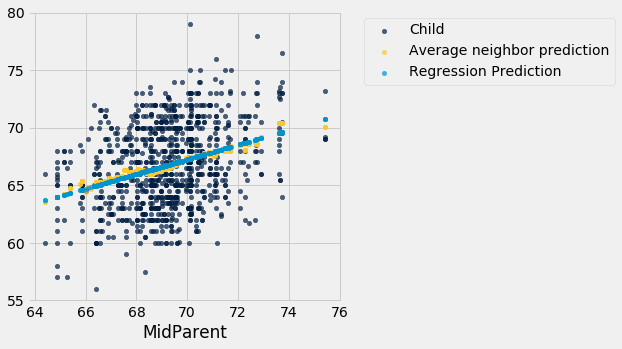

In [29]:
heights_with_predictions.scatter('MidParent')

### Regression line vs other lines

In [30]:
def demographics_errors(slope, intercept):
    # Use four convenient points from the original data
    sample = [[14.7, 33995], [19.1, 61454], [50.7, 71183], [59.5, 105918]]
    demographics.scatter('College%', 'Median Income', alpha=0.5)
    xlims = make_array(5, 75)
    # Plot a line with the slope and intercept you specified:
    plots.plot(xlims, slope * xlims + intercept, lw=4)
    # Plot red lines from each of the four points to the line
    for x, y in sample:
        plots.plot([x, x], [y, slope * x + intercept], color='r', lw=4)

In [31]:
def fitted_values(t, x, y):
    """Return an array of the regressions estimates at all the x values"""
    a = slope(t, x, y)
    b = intercept(t, x, y)
    return a*t.column(x) + b

In [32]:
demographics = Table.read_table('data/district_demographics2016.csv')
demographics.show(5)

State,District,Median Income,Percent voting for Clinton,College%
Alabama,"Congressional District 1 (115th Congress), Alabama",47083,34.1,24
Alabama,"Congressional District 2 (115th Congress), Alabama",42035,33,21.8
Alabama,"Congressional District 3 (115th Congress), Alabama",46544,32.3,22.8
Alabama,"Congressional District 4 (115th Congress), Alabama",41110,17.4,17
Alabama,"Congressional District 5 (115th Congress), Alabama",51690,31.3,30.3


In [33]:
demographics = demographics.drop(
    'State', 'District', 'Percent voting for Clinton')
demographics.show(5)

Median Income,College%
47083,24
42035,21.8
46544,22.8
41110,17
51690,30.3


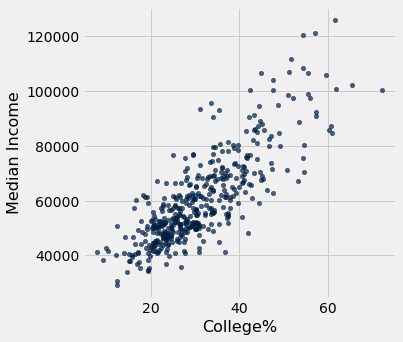

In [34]:
demographics.scatter('College%', 'Median Income')

In [35]:
correlation(demographics, 'College%', 'Median Income')

0.8184648517141335

In [36]:
regression_slope = slope(demographics, 'College%', 'Median Income')
regression_intercept = intercept(demographics, 'College%', 'Median Income')
regression_slope, regression_intercept

(1270.70168946388, 20802.577766677925)

In [37]:
predicted = fitted_values(demographics, 'College%', 'Median Income')

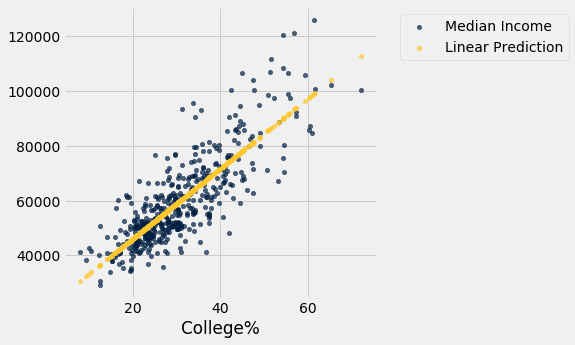

In [38]:
demographics = demographics.with_column(
    'Linear Prediction', predicted)
demographics.scatter('College%')

In [39]:
actual = demographics.column('Median Income')
errors = actual - predicted

In [40]:
demographics.with_column('Error', errors)

Median Income,College%,Linear Prediction,Error
47083,24,51299.4,-4216.42
42035,21.8,48503.9,-6468.87
46544,22.8,49774.6,-3230.58
41110,17,42404.5,-1294.51
51690,30.3,59304.8,-7614.84
61413,36.7,67437.3,-6024.33
34664,19.4,45454.2,-10790.2
76440,29.6,58415.3,18024.7
50537,24.5,51934.8,-1397.77
49072,34,64006.4,-14934.4


In [41]:
np.mean(errors)

6.356008950321154e-13

In [42]:
np.mean(errors ** 2) ** 0.5

9398.515588571281

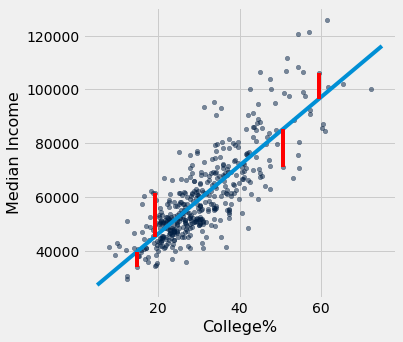

In [43]:
demographics_errors(regression_slope, regression_intercept)

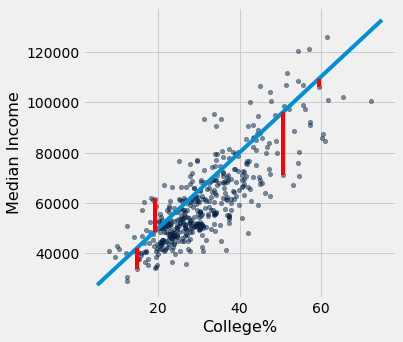

In [44]:
# takes any slope, any intercept

demographics_errors(1500, 20000)

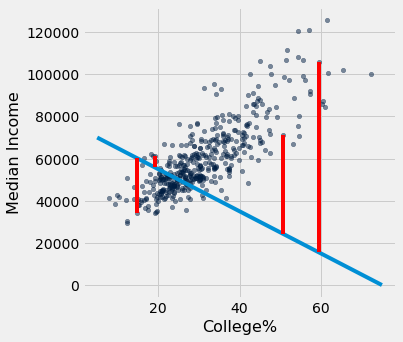

In [45]:
demographics_errors(-1000, 75000)

### Root Mean Square Error ###

In [46]:
def show_demographics_rmse(slope, intercept):
    demographics_errors(slope, intercept)
    x = demographics.column('College%')
    y = demographics.column('Median Income')
    prediction = slope * x + intercept
    mse = np.mean((y - prediction) ** 2)
    print("Root mean squared error:", round(mse ** 0.5, 2))

Root mean squared error: 30247.88


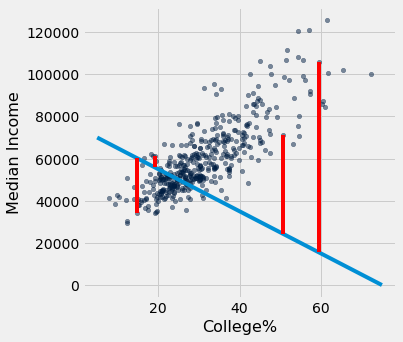

In [47]:
show_demographics_rmse(-1000, 75000)

Root mean squared error: 11559.09


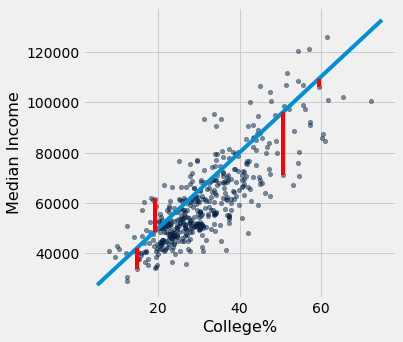

In [48]:
show_demographics_rmse(1500, 20000)

Root mean squared error: 9398.52


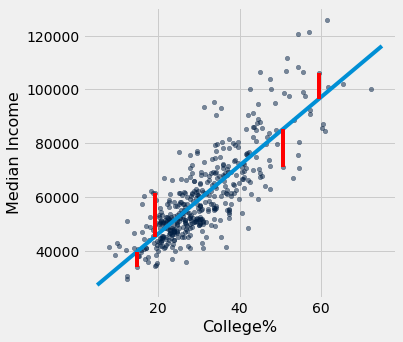

In [49]:
show_demographics_rmse(regression_slope, regression_intercept)

### Numerical Optimization ###

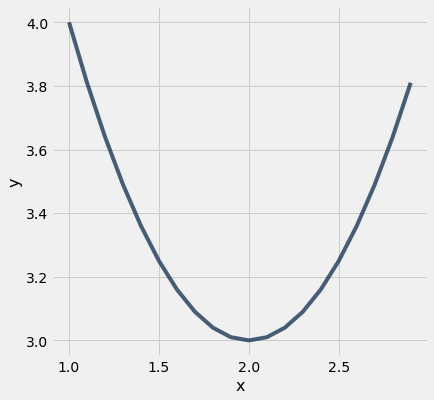

In [50]:
x = np.arange(1, 3, 0.1)
y = (x-2)**2 + 3
Table().with_columns('x', x, 'y', y).plot('x')

In [51]:
def f(x):
    return ((x-2)**2) + 3

In [52]:
minimize(f)

1.9999999946252267

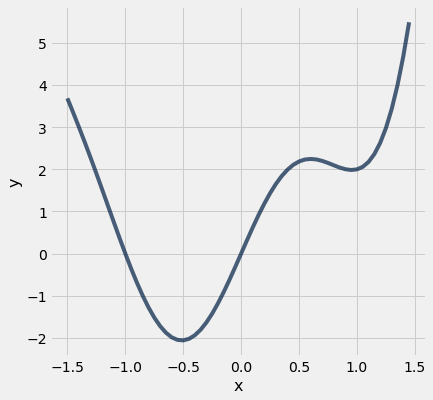

In [53]:
x = np.arange(-1.5, 1.5, 0.05)
y2 = 2 * np.sin(x*np.pi) + x ** 3 + x ** 4 
Table().with_columns('x', x, 'y', y2).plot('x')

In [54]:
def complicated_function(x):
    return 2 * np.sin(x*np.pi) + x ** 3 + x ** 4 

In [55]:
minimize(complicated_function)

-0.5126437620940081

### Minimizing RMSE ###

In [56]:
def demographics_rmse(any_slope, any_intercept):
    x = demographics.column('College%')
    y = demographics.column('Median Income')
    estimate = any_slope*x + any_intercept
    return (np.mean((y - estimate) ** 2)) ** 0.5

In [57]:
demographics_rmse(1500, 20000)

11559.086490075999

In [58]:
demographics_rmse(-1000, 75000)

30247.883767944502

In [59]:
minimize(demographics_rmse)

array([ 1270.70168805, 20802.57933807])

In [60]:
make_array(regression_slope, regression_intercept)

array([ 1270.70168946, 20802.57776668])

In [ ]:
# turns out our regression line is our best fitting line, 
# that gives us the least amount of error
# best possible RMSE

### Nonlinear Regression ###

In [61]:
shotput = Table.read_table('data/shotput.csv')
shotput

Weight Lifted,Shot Put Distance
37.5,6.4
51.5,10.2
61.3,12.4
61.3,13
63.6,13.2
66.1,13
70,12.7
92.7,13.9
90.5,15.5
90.5,15.8


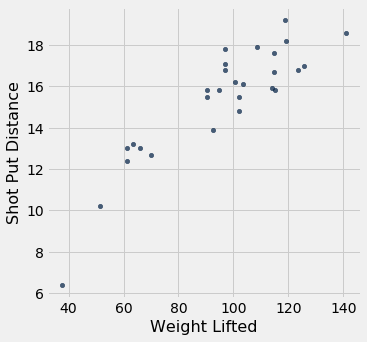

In [62]:
shotput.scatter('Weight Lifted')

In [63]:
def shotput_linear_rmse(any_slope, any_intercept):
    x = shotput.column('Weight Lifted')
    y = shotput.column('Shot Put Distance')
    estimate = any_slope*x + any_intercept
    return np.mean((y - estimate) ** 2) ** 0.5

In [64]:
best_line = minimize(shotput_linear_rmse)
best_line

array([0.09834382, 5.95962883])

In [65]:
weights = shotput.column(0)

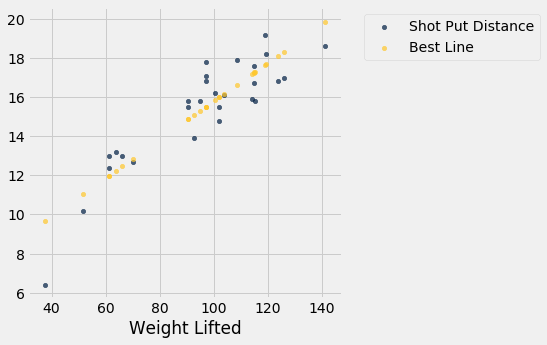

In [66]:
linear_fit = best_line.item(0)*weights + best_line.item(1)

shotput.with_column(
    'Best Line', linear_fit
).scatter(0)

**Quadratic Function**

$$
f(x) ~=~ ax^2 + bx + c
$$
for constants $a$, $b$, and $c$.



In [67]:
def shotput_quadratic_rmse(a, b, c):
    x = shotput.column('Weight Lifted')
    y = shotput.column('Shot Put Distance')
    estimate = a*(x**2) + b*x + c
    return np.mean((y - estimate) ** 2) ** 0.5

In [68]:
best_quad = minimize(shotput_quadratic_rmse)
best_quad

array([-1.04003731e-03,  2.82706003e-01, -1.53167618e+00])

In [69]:
# x = weight lifted = 100 kg
# Then predicted shot put distance:

(-0.00104)*(100**2) + 0.2827*100 - 1.5318

16.3382

In [70]:
quad_fit = best_quad.item(0)*(weights**2) + best_quad.item(1)*weights + best_quad.item(2)

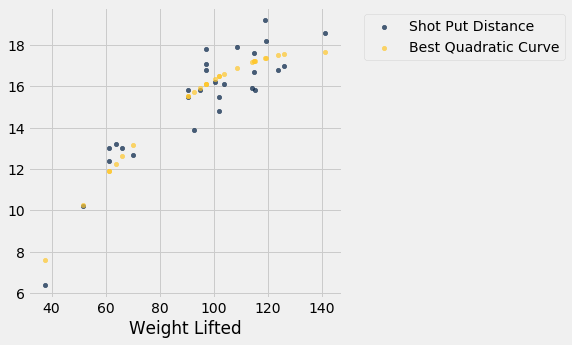

In [71]:
shotput.with_column('Best Quadratic Curve', quad_fit).scatter(0)